In [19]:
!pip install mnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
#conv

import numpy as np

class Conv3x3:
  def __init__(self, num_filters):
    self.num_filters = num_filters
    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):
    h, w = image.shape

    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):
    self.last_input = input

    h, w = input.shape
    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    d_L_d_filters = np.zeros(self.filters.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region
    self.filters -= learn_rate * d_L_d_filters
    return None

In [21]:
# maxpool

import numpy as np

class MaxPool2:
  def iterate_regions(self, image):
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            # If this pixel was the max value, copy the gradient to it.
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

In [22]:
# softmax

import numpy as np

class Softmax:
  def __init__(self, input_len, nodes):
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    self.last_input_shape = input.shape

    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape

    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals

    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue
      t_exp = np.exp(self.last_totals)
      S = np.sum(t_exp)

      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      d_L_d_t = gradient * d_out_d_t

      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      # Update weights / biases
      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

--- Epoch 1 ---
[Step 100] Past 100 steps: Average Loss 2.234 | Accuracy: 17%
[Step 200] Past 100 steps: Average Loss 2.077 | Accuracy: 34%
[Step 300] Past 100 steps: Average Loss 1.634 | Accuracy: 53%
[Step 400] Past 100 steps: Average Loss 1.161 | Accuracy: 69%
[Step 500] Past 100 steps: Average Loss 0.997 | Accuracy: 70%
[Step 600] Past 100 steps: Average Loss 0.887 | Accuracy: 70%
[Step 700] Past 100 steps: Average Loss 0.670 | Accuracy: 82%
[Step 800] Past 100 steps: Average Loss 0.636 | Accuracy: 77%
[Step 900] Past 100 steps: Average Loss 0.622 | Accuracy: 78%
[Step 1000] Past 100 steps: Average Loss 0.560 | Accuracy: 85%
[Step 1100] Past 100 steps: Average Loss 0.461 | Accuracy: 85%
[Step 1200] Past 100 steps: Average Loss 0.830 | Accuracy: 74%
[Step 1300] Past 100 steps: Average Loss 0.498 | Accuracy: 85%
[Step 1400] Past 100 steps: Average Loss 0.452 | Accuracy: 83%
[Step 1500] Past 100 steps: Average Loss 0.458 | Accuracy: 83%
[Step 1600] Past 100 steps: Average Loss 0.532 |

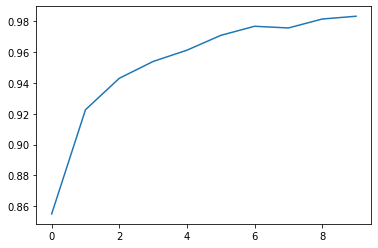

In [23]:
# run

import mnist
import numpy as np

n = 10000
train_images = mnist.train_images()[:n]
train_labels = mnist.train_labels()[:n]
test_images = mnist.test_images()[:n]
test_labels = mnist.test_labels()[:n]

conv = Conv3x3(8)                  # 28x28x1 -> 26x26x8
pool = MaxPool2()                  # 26x26x8 -> 13x13x8
softmax = Softmax(13 * 13 * 8, 10) # 13x13x8 -> 10

def forward(image, label):
  out = conv.forward((image / 255) - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)

  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  out, loss, acc = forward(im, label)

  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]

  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc


# Train the CNN for k epochs

acc_g = []
for epoch in range(10):
  print('--- Epoch %d ---' % (epoch + 1))

  permutation = np.random.permutation(len(train_images))
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]

  loss = 0
  num_correct = 0

  corr_pred = 0
  

  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 100 == 99:
      print(
        '[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 100, num_correct)
      )
      loss = 0
      num_correct = 0

    l, acc = train(im, label)
    loss += l
    num_correct += acc
    corr_pred += acc
  acc_g.append(corr_pred/n)
  corr_pred = 0

print ('Accuracy over epochs: ', acc_g)
plt.plot(acc_g)

# Test the CNN
print('\n--- Testing the CNN ---')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss:', loss / num_tests)
print('Test Accuracy:', num_correct / num_tests)

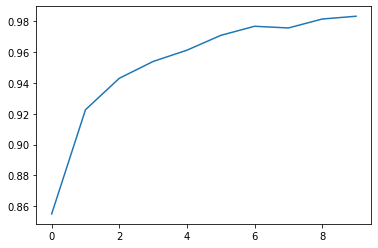

In [24]:
import matplotlib.pyplot as plt
plt.plot(acc_g)